In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mindspore import Tensor, context, dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms.transforms as C
import mindspore.dataset.vision as CV
import mindspore.nn as nn
import mindspore.ops as ops

In [5]:


context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# 加载MNIST数据集
def load_data():
    train_data = ds.MnistDataset(dataset_dir='.', usage='train')
    test_data = ds.MnistDataset(dataset_dir='.', usage='test')

    # 数据处理
    transform = [
        CV.Resize((28, 28)),
        CV.Rescale(1.0 / 255.0, 0.0),
        CV.Rescale(2.0, -1.0),  # 转换为[-1, 1]
        CV.HWC2CHW()
    ]
    type_cast_op = C.TypeCast(mstype.int32)

    train_data = train_data.map(operations=type_cast_op, input_columns="label")
    test_data = test_data.map(operations=type_cast_op, input_columns="label")

    train_data = train_data.map(operations=transform, input_columns="image")
    test_data = test_data.map(operations=transform, input_columns="image")

    # 批处理和打乱数据
    train_data = train_data.batch(64, drop_remainder=True)
    test_data = test_data.batch(64, drop_remainder=True)

    return train_data, test_data

train_data, test_data = load_data()


In [6]:
# import mindspore.nn as nn
# from mindspore import context, dtype as mstype
# import mindspore.ops as ops

# import numpy as np
# import struct
# import gzip
# import matplotlib.pyplot as plt


# context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# class OptimizedMultinomialNaiveBayes(nn.Cell):
#     def __init__(self, alpha=1.0):
#         super(OptimizedMultinomialNaiveBayes, self).__init__()
#         self.alpha = alpha
#         self.classes = None
#         self.class_count = None
#         self.feature_count = None
#         self.class_log_prior = None
#         self.feature_log_prob = None

#     def fit(self, X, y):
#         self.classes = np.unique(y)
#         n_classes = len(self.classes)
#         n_features = X.shape[1]
#         self.class_count = np.zeros(n_classes)
#         self.feature_count = np.zeros((n_classes, n_features))

#         for idx, c in enumerate(self.classes):
#             X_c = X[y == c]
#             self.class_count[idx] = X_c.shape[0]
#             self.feature_count[idx, :] = np.sum(X_c, axis=0)

#         self.class_log_prior = np.log(self.class_count / np.sum(self.class_count))
#         self.feature_log_prob = np.log((self.feature_count + self.alpha) / (self.class_count[:, None] + self.alpha * n_features))

#     def construct(self, X):
#         log_likelihood = ops.matmul(Tensor(X, mstype.float32), Tensor(self.feature_log_prob.T, mstype.float32))
#         log_posterior = log_likelihood + Tensor(self.class_log_prior, mstype.float32)
#         return self.classes[np.argmax(log_posterior.asnumpy(), axis=1)]

# omnb = OptimizedMultinomialNaiveBayes(alpha=1.0)


# def read_images(file_path):
#     with gzip.open(file_path, 'rb') as f:
#         # 读取文件头信息：魔数和图片数量
#         magic, num_images = struct.unpack(">II", f.read(8))
#         # 读取图片的行数和列数
#         num_rows, num_cols = struct.unpack(">II", f.read(8))
#         print(f"Magic number: {magic}, Number of images: {num_images}, Rows: {num_rows}, Columns: {num_cols}")
#         # 读取图片数据
#         images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
#         return images

# def read_labels(file_path):
#     with gzip.open(file_path, 'rb') as f:
#         # 读取文件头信息：魔数和标签数量
#         magic, num_labels = struct.unpack(">II", f.read(8))
#         print(f"Magic number: {magic}, Number of labels: {num_labels}")
#         # 读取标签数据
#         labels = np.frombuffer(f.read(), dtype=np.uint8)
#         return labels

# # 设置数据集文件路径
# train_images_path = 'data/train-images-idx3-ubyte.gz'
# train_labels_path = 'data/train-labels-idx1-ubyte.gz'
# test_images_path = 'data/t10k-images-idx3-ubyte.gz'
# test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# # 读取数据集
# X_train = read_images(train_images_path)
# y_train = read_labels(train_labels_path)
# X_test = read_images(test_images_path)
# y_test = read_labels(test_labels_path)

# # 将像素值归一化到[0, 1]范围
# X_train = X_train / 255.0
# X_test = X_test / 255.0

# # 将图像二值化
# X_train = (X_train > 0.5).astype(int)
# X_test = (X_test > 0.5).astype(int)

# # 将图像展开成一维向量
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)


# omnb.fit(X_train, y_train)
# predictions = omnb.construct(X_test)
# accuracy = np.mean(predictions == y_test)
# print(f'Accuracy: {accuracy}')


import mindspore.nn as nn
from mindspore import context, dtype as mstype, Tensor
import mindspore.ops as ops
import mindspore.dataset as ds

import numpy as np
import struct
import gzip
import matplotlib.pyplot as plt

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

class OptimizedMultinomialNaiveBayes(nn.Cell):
    def __init__(self, alpha=1.0):
        super(OptimizedMultinomialNaiveBayes, self).__init__()
        self.alpha = alpha
        self.classes = None
        self.class_count = None
        self.feature_count = None
        self.class_log_prior = None
        self.feature_log_prob = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.class_count = np.zeros(n_classes)
        self.feature_count = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_count[idx] = X_c.shape[0]
            self.feature_count[idx, :] = np.sum(X_c, axis=0)

        self.class_log_prior = np.log(self.class_count / np.sum(self.class_count))
        self.feature_log_prob = np.log((self.feature_count + self.alpha) / (self.class_count[:, None] + self.alpha * n_features))

    def construct(self, X):
        log_likelihood = ops.matmul(Tensor(X, mstype.float32), Tensor(self.feature_log_prob.T, mstype.float32))
        log_posterior = log_likelihood + Tensor(self.class_log_prior, mstype.float32)
        return self.classes[np.argmax(log_posterior.asnumpy(), axis=1)]

def read_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        # 读取文件头信息：魔数和图片数量
        magic, num_images = struct.unpack(">II", f.read(8))
        # 读取图片的行数和列数
        num_rows, num_cols = struct.unpack(">II", f.read(8))
        print(f"Magic number: {magic}, Number of images: {num_images}, Rows: {num_rows}, Columns: {num_cols}")
        # 读取图片数据
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

def read_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        # 读取文件头信息：魔数和标签数量
        magic, num_labels = struct.unpack(">II", f.read(8))
        print(f"Magic number: {magic}, Number of labels: {num_labels}")
        # 读取标签数据
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# 设置数据集文件路径
train_images_path = 'data/train-images-idx3-ubyte.gz'
train_labels_path = 'data/train-labels-idx1-ubyte.gz'
test_images_path = 'data/t10k-images-idx3-ubyte.gz'
test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# 读取数据集
X_train = read_images(train_images_path)
y_train = read_labels(train_labels_path)
X_test = read_images(test_images_path)
y_test = read_labels(test_labels_path)

# 将像素值归一化到[0, 1]范围
X_train = X_train / 255.0
X_test = X_test / 255.0

# 将图像二值化
X_train = (X_train > 0.5).astype(int)
X_test = (X_test > 0.5).astype(int)

# 将图像展开成一维向量
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 转换为MindSpore的Tensor格式
X_train = Tensor(X_train, mstype.float32)
y_train = Tensor(y_train, mstype.int32)
X_test = Tensor(X_test, mstype.float32)
y_test = Tensor(y_test, mstype.int32)

# 创建和训练模型
omnb = OptimizedMultinomialNaiveBayes(alpha=1.0)
omnb.fit(X_train.asnumpy(), y_train.asnumpy())

# 进行预测并计算准确率
predictions = omnb.construct(X_test)
accuracy = np.mean(predictions == y_test.asnumpy())
print(f'Accuracy: {accuracy}')


Magic number: 2051, Number of images: 60000, Rows: 28, Columns: 28
Magic number: 2049, Number of labels: 60000
Magic number: 2051, Number of images: 10000, Rows: 28, Columns: 28
Magic number: 2049, Number of labels: 10000
Accuracy: 0.7026


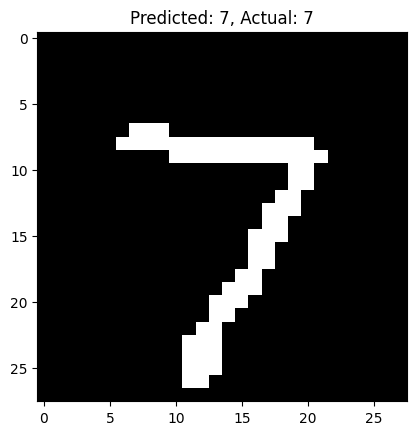

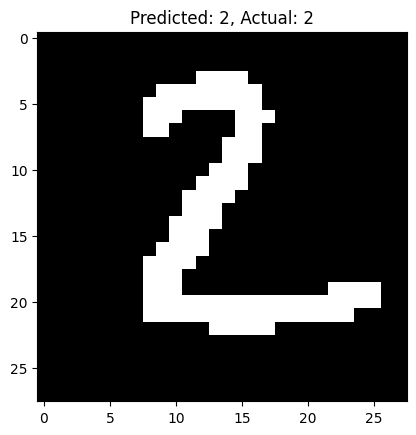

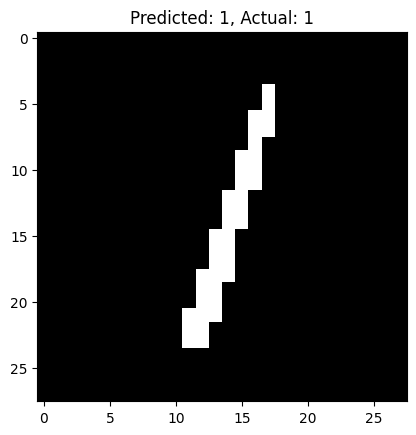

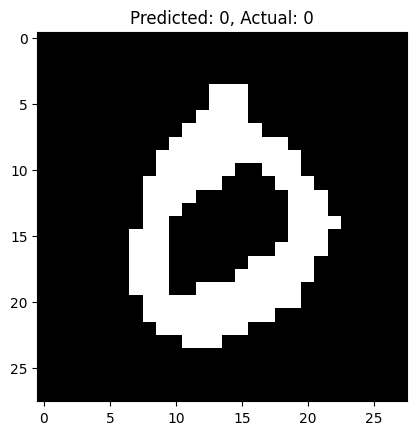

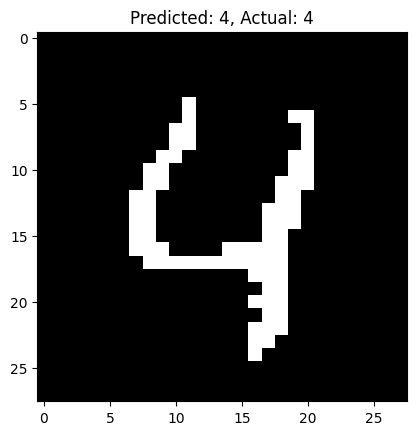

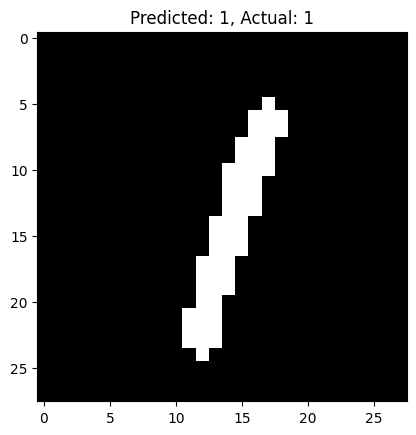

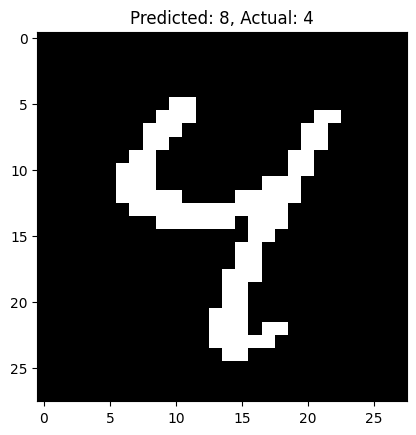

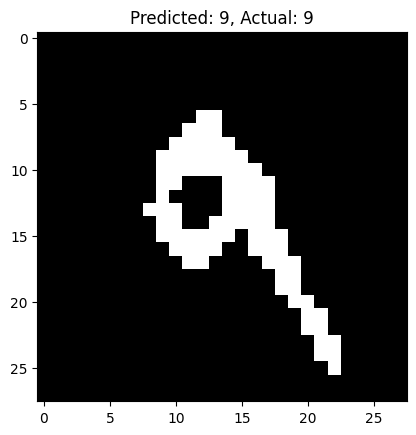

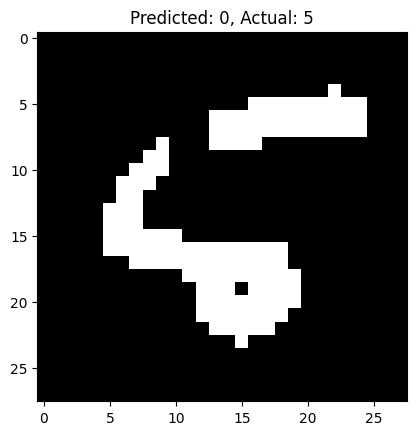

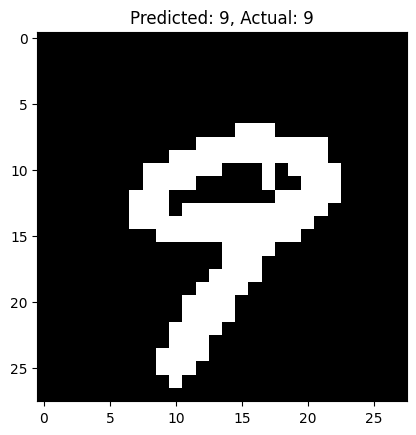

In [7]:
for i in range(10):
    plt.imshow(X_test[i].asnumpy().reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predictions[i]}, Actual: {y_test.asnumpy()[i]}')
    plt.show()

# for i in range(10):
#     plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
#     plt.title(f'Predicted: {predictions[i]}, Actual: {y_test[i]}')
#     plt.show()


In [8]:
import mindspore.nn as nn
from mindspore import context, dtype as mstype, Tensor
import mindspore.ops as ops
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C

import numpy as np
import matplotlib.pyplot as plt

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

class OptimizedMultinomialNaiveBayes(nn.Cell):
    def __init__(self, alpha=1.0):
        super(OptimizedMultinomialNaiveBayes, self).__init__()
        self.alpha = alpha
        self.classes = None
        self.class_count = None
        self.feature_count = None
        self.class_log_prior = None
        self.feature_log_prob = None

    def fit(self, X, y):
        self.classes = np.unique(y.asnumpy())
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.class_count = np.zeros(n_classes)
        self.feature_count = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_count[idx] = X_c.shape[0]
            self.feature_count[idx, :] = np.sum(X_c.asnumpy(), axis=0)

        self.class_log_prior = np.log(self.class_count / np.sum(self.class_count))
        self.feature_log_prob = np.log((self.feature_count + self.alpha) / (self.class_count[:, None] + self.alpha * n_features))

    def construct(self, X):
        log_likelihood = ops.matmul(X, Tensor(self.feature_log_prob.T, mstype.float32))
        log_posterior = log_likelihood + Tensor(self.class_log_prior, mstype.float32)
        return self.classes[np.argmax(log_posterior.asnumpy(), axis=1)]

def load_data():
    train_data = ds.MnistDataset(dataset_dir='data', usage='train')
    test_data = ds.MnistDataset(dataset_dir='data', usage='test')

    # 数据处理
    transform = [
        CV.Resize((28, 28)),
        CV.Rescale(1.0 / 255.0, 0.0),
        CV.Rescale(2.0, -1.0),  # 转换为[-1, 1]
        CV.HWC2CHW()
    ]
    type_cast_op = C.TypeCast(mstype.int32)

    train_data = train_data.map(operations=type_cast_op, input_columns="label")
    test_data = test_data.map(operations=type_cast_op, input_columns="label")

    train_data = train_data.map(operations=transform, input_columns="image")
    test_data = test_data.map(operations=transform, input_columns="image")

    # 批处理和打乱数据
    train_data = train_data.batch(64, drop_remainder=True)
    test_data = test_data.batch(64, drop_remainder=True)

    return train_data, test_data

train_data, test_data = load_data()

# 训练模型
for data in train_data.create_dict_iterator():
    X_train = data["image"]
    y_train = data["label"]

    # 预处理
    X_train = X_train.asnumpy().reshape(X_train.shape[0], -1)
    y_train = y_train.asnumpy()

    omnb = OptimizedMultinomialNaiveBayes(alpha=1.0)
    omnb.fit(Tensor(X_train, mstype.float32), Tensor(y_train, mstype.int32))

# 测试模型并计算准确率
accuracies = []
for data in test_data.create_dict_iterator():
    X_test = data["image"]
    y_test = data["label"]

    # 预处理
    X_test = X_test.asnumpy().reshape(X_test.shape[0], -1)
    y_test = y_test.asnumpy()

    predictions = omnb.construct(Tensor(X_test, mstype.float32))
    accuracy = np.mean(predictions == y_test)
    accuracies.append(accuracy)

print(f'Average Accuracy: {np.mean(accuracies)}')

# 显示预测结果和实际标签
for i in range(10):
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predictions[i]}, Actual: {y_test[i]}')
    plt.show()


[WARNING] ME(17228:3936,MainProcess):2024-05-31-20:51:34.890.485 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(17228:3936,MainProcess):2024-05-31-20:51:34.890.485 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(17228:3936,MainProcess):2024-05-31-20:51:34.890.485 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(17228:3936,MainProcess):2024-05-31-20:51:34.895.152 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW

RuntimeError: 

Magic number: 2051, Number of images: 60000, Rows: 28, Columns: 28
Magic number: 2049, Number of labels: 60000
Magic number: 2051, Number of images: 10000, Rows: 28, Columns: 28
Magic number: 2049, Number of labels: 10000
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Accuracy: 0.8427


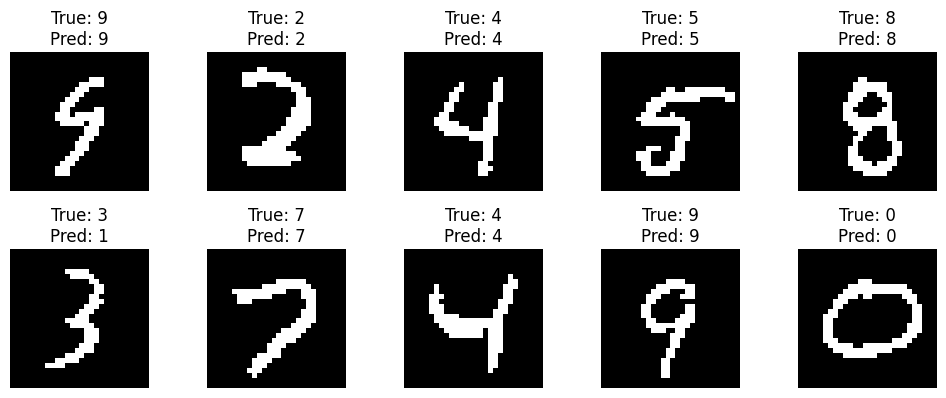

In [9]:
import numpy as np
import struct
import gzip
import matplotlib.pyplot as plt
import mindspore
from mindspore import Tensor
from mindspore.dataset import vision

def read_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic, num_images = struct.unpack(">II", f.read(8))
        num_rows, num_cols = struct.unpack(">II", f.read(8))
        print(f"Magic number: {magic}, Number of images: {num_images}, Rows: {num_rows}, Columns: {num_cols}")
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

def read_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        print(f"Magic number: {magic}, Number of labels: {num_labels}")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

train_images_path = 'data/train-images-idx3-ubyte.gz'
train_labels_path = 'data/train-labels-idx1-ubyte.gz'
test_images_path = 'data/t10k-images-idx3-ubyte.gz'
test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

X_train = read_images(train_images_path)
y_train = read_labels(train_labels_path)
X_test = read_images(test_images_path)
y_test = read_labels(test_labels_path)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = (X_train > 0.5).astype(int)
X_test = (X_test > 0.5).astype(int)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_priors = {}
        self.feature_probs = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        for cls in self.classes:
            X_cls = X[y == cls]
            self.class_priors[cls] = X_cls.shape[0] / n_samples
            self.feature_probs[cls] = (X_cls.sum(axis=0) + 1) / (X_cls.shape[0] + 2)

    def predict(self, X):
        posteriors = []
        for x in X:
            posterior_probs = {}
            for cls in self.classes:
                prior = np.log(self.class_priors[cls])
                conditional = np.sum(np.log(self.feature_probs[cls]) * x + np.log(1 - self.feature_probs[cls]) * (1 - x))
                posterior_probs[cls] = prior + conditional
            posteriors.append(max(posterior_probs, key=posterior_probs.get))
        return np.array(posteriors)

nb = NaiveBayes()

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

import random

indices = random.sample(range(X_test.shape[0]), 10)
images = X_test[indices].reshape(-1, 28, 28)
true_labels = y_test[indices]
pred_labels = y_pred[indices]

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
import mindspore
import mindspore.dataset as ds
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as vision
from mindspore import Tensor, nn, context
import mindspore.numpy as mnp

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# 下载并加载MNIST数据集
import os
import requests

requests.packages.urllib3.disable_warnings()

def download_dataset(dataset_url, path):
    filename = dataset_url.split("/")[-1]
    save_path = os.path.join(path, filename)
    if os.path.exists(save_path):
        return
    if not os.path.exists(path):
        os.makedirs(path)
    res = requests.get(dataset_url, stream=True, verify=False)
    with open(save_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(dataset_url), path))

train_path = "datasets/MNIST_Data/train"
test_path = "datasets/MNIST_Data/test"

download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte", test_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte", test_path)



def load_mnist_data(batch_size=32):
    mnist_train = ds.MnistDataset(train_path)
    mnist_test = ds.MnistDataset(test_path)

    # 数据处理
    transform = [
        vision.ToType(mindspore.float32),
        vision.Resize((28, 28)),
        vision.Rescale(1.0 / 255.0, 0.0),
        C.TypeCast(mindspore.int32)
    ]

    mnist_train = mnist_train.map(operations=transform, input_columns="image")
    mnist_train = mnist_train.batch(batch_size)

    mnist_test = mnist_test.map(operations=transform, input_columns="image")
    mnist_test = mnist_test.batch(batch_size)

    return mnist_train, mnist_test

# 朴素贝叶斯模型
class NaiveBayesClassifier(nn.Cell):
    def __init__(self, num_classes=10, num_features=784):
        super(NaiveBayesClassifier, self).__init__()
        self.num_classes = num_classes
        self.num_features = num_features
        self.class_priors = mindspore.Parameter(Tensor(mnp.zeros(num_classes), mindspore.float32))
        self.feature_means = mindspore.Parameter(Tensor(mnp.zeros((num_classes, num_features)), mindspore.float32))
        self.feature_variances = mindspore.Parameter(Tensor(mnp.zeros((num_classes, num_features)), mindspore.float32))

    def train(self, train_dataset):
        class_counts = Tensor(mnp.zeros(self.num_classes), mindspore.float32)
        feature_sums = Tensor(mnp.zeros((self.num_classes, self.num_features)), mindspore.float32)
        feature_squared_sums = Tensor(mnp.zeros((self.num_classes, self.num_features)), mindspore.float32)

        for data in train_dataset.create_dict_iterator():
            images = data["image"]
            labels = data["label"]
            for i in range(len(labels)):
                label = labels[i]
                class_counts[label] += 1
                feature_sums[label] += images[i]
                feature_squared_sums[label] += images[i] ** 2

        self.class_priors.set_data(class_counts / mnp.sum(class_counts))
        self.feature_means.set_data(feature_sums / class_counts[:, None])
        self.feature_variances.set_data((feature_squared_sums / class_counts[:, None]) - (self.feature_means ** 2))

    def predict(self, images):
        log_priors = mnp.log(self.class_priors)
        predictions = []

        for image in images:
            log_likelihoods = []

            for c in range(self.num_classes):
                log_likelihood = mnp.sum(
                    -0.5 * mnp.log(2 * mnp.pi * self.feature_variances[c])
                    - 0.5 * ((image - self.feature_means[c]) ** 2) / self.feature_variances[c]
                )
                log_likelihoods.append(log_priors[c] + log_likelihood)

            predictions.append(mnp.argmax(log_likelihoods))

        return Tensor(predictions, mindspore.int32)

    def accuracy(self, test_dataset):
        correct = 0
        total = 0

        for data in test_dataset.create_dict_iterator():
            images = data["image"]
            labels = data["label"]
            predictions = self.predict(images)
            correct += mnp.sum(predictions == labels).asnumpy()
            total += len(labels)

        return correct / total

# 函数调用
def run_naive_bayes():
    train_dataset, test_dataset = load_mnist_data()

    nb_classifier = NaiveBayesClassifier()
    nb_classifier.train(train_dataset)

    accuracy = nb_classifier.accuracy(test_dataset)
    return accuracy

# 调用函数并输出结果
accuracy = run_naive_bayes()
print(f"Accuracy: {accuracy * 100:.2f}%")


The train-labels-idx1-ubyte file is downloaded and saved in the path datasets/MNIST_Data/train after processing
The train-images-idx3-ubyte file is downloaded and saved in the path datasets/MNIST_Data/train after processing
The t10k-labels-idx1-ubyte file is downloaded and saved in the path datasets/MNIST_Data/test after processing
The t10k-images-idx3-ubyte file is downloaded and saved in the path datasets/MNIST_Data/test after processing


IndexError: The tensor index must be int or bool type, but got 9

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore\ccsrc\pybind_api\ir\tensor_index_py.cc:1442 mindspore::tensor::TensorIndex::GetItemByTensor
